**Installing Necessary Libraries**

In [1]:
!pip install sentence-transformers scikit-learn pandas numpy

**Importing Necessary Libraries**

In [31]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold


from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

Stopwords removing Toggle

In [9]:
REMOVE_STOPWORDS = True

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

STOPWORDS = set(stopwords.words("english"))

def remove_stopwords(text):
    if not isinstance(text, str):
        return text
    return " ".join(t for t in text.split() if t.lower() not in STOPWORDS)

Implementing Basic Text Normalization : Creating the preprocessing function

In [11]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # lowercase
    text = text.lower()

    # removing special characters and punctuation (keep letters, numbers, spaces)
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # removing extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [13]:
df = pd.read_csv("fake_news_dataset.csv")

# Filling null values
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

**Mapping Labels**

In [15]:
# Remove leading/trailing spaces and convert to lowercase
df['label'] = df['label'].str.strip().str.lower()

# Map to integers
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Drop rows that didn’t match 'real' or 'fake'
df = df[df['label'].notnull()]

# Convert to int
df['label'] = df['label'].astype(int)

# Safety check
assert df['label'].isnull().sum() == 0
print("Rows left after label processing:", len(df))


Rows left after label processing: 20000


In [17]:
df['content'] = df['title'] + " " + df['text']

In [19]:
df["content"] = df["content"].apply(clean_text)
if REMOVE_STOPWORDS:
    df["content"] = df["content"].apply(remove_stopwords)

**Loading Model for text processing**

In [21]:
model = SentenceTransformer('all-MiniLM-L6-v2')

X = model.encode(
    df['content'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

**Setting y**

In [22]:
y = df['label'].values

**Train-Test Split**

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [35]:
accuracy_list = []
f1_list = []


**Performance Evaluation of Logistic Regression using Stratified 5-Fold Cross-Validation**

In [83]:
accuracies = []
f1_scores = []
precisions = []
recalls = []


for fold, (train_index, test_index) in enumerate(skf.split(X, y)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    precisions.append(prec)
    recalls.append(rec)

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1} Accuracy:", acc)
    print(f"Fold {fold+1} F1:", f1)

# OUTSIDE LOOP
avg_lr_accuracy = sum(accuracies) / len(accuracies)
avg_lr_f1 = sum(f1_scores) / len(f1_scores)
avg_lr_precision = sum(precisions)/len(precisions)
avg_lr_recall = sum(recalls)/len(recalls)


print("Average Accuracy:", avg_lr_accuracy)
print("Average F1:", avg_lr_f1)




Fold 1 Accuracy: 0.49625
Fold 1 F1: 0.4920594907990925
Fold 2 Accuracy: 0.49825
Fold 2 F1: 0.4966139954853273
Fold 3 Accuracy: 0.4935
Fold 3 F1: 0.49627051218299356
Fold 4 Accuracy: 0.50075
Fold 4 F1: 0.5104192203971561
Fold 5 Accuracy: 0.5025
Fold 5 F1: 0.5074257425742574
Average Accuracy: 0.49824999999999997
Average F1: 0.5005577922877654


In [41]:
# GridSearch using existing classifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# REQUIRED OUTPUT
print("Best parameters:", grid_search.best_params_)

# overwrite clf with tuned model
clf = grid_search.best_estimator_


Best parameters: {'C': 10, 'penalty': 'l2'}


Adjusting Classification Threshold and Visualizing Precision-Recall

In [63]:
def predict_with_threshold(probs, threshold=0.5):
    """
    Convert predicted probabilities into class labels based on a custom threshold.

    Args:
        probs (array-like): Probabilities of the positive class
        threshold (float): Threshold for labeling as positive

    Returns:
        numpy array of 0/1 predictions
    """
    return (probs > threshold).astype(int)


In [65]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

threshold = 0.5

threshold_accuracies = []
threshold_f1_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"\nFold {fold+1}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_test)[:, 1]
    y_pred_custom = predict_with_threshold(probs, threshold)

    acc = accuracy_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)

    threshold_accuracies.append(acc)
    threshold_f1_scores.append(f1)

    print("Accuracy:", acc)
    print("F1:", f1)

print("\nAverage Threshold Accuracy:", sum(threshold_accuracies)/len(threshold_accuracies))
print("Average Threshold F1:", sum(threshold_f1_scores)/len(threshold_f1_scores))



Fold 1
Accuracy: 0.49625
F1: 0.4920594907990925

Fold 2
Accuracy: 0.49825
F1: 0.4966139954853273

Fold 3
Accuracy: 0.4935
F1: 0.49627051218299356

Fold 4
Accuracy: 0.50075
F1: 0.5104192203971561

Fold 5
Accuracy: 0.5025
F1: 0.5074257425742574

Average Threshold Accuracy: 0.49824999999999997
Average Threshold F1: 0.5005577922877654


In [ ]:
** Precision–Recall curve based on the LAST fold only**

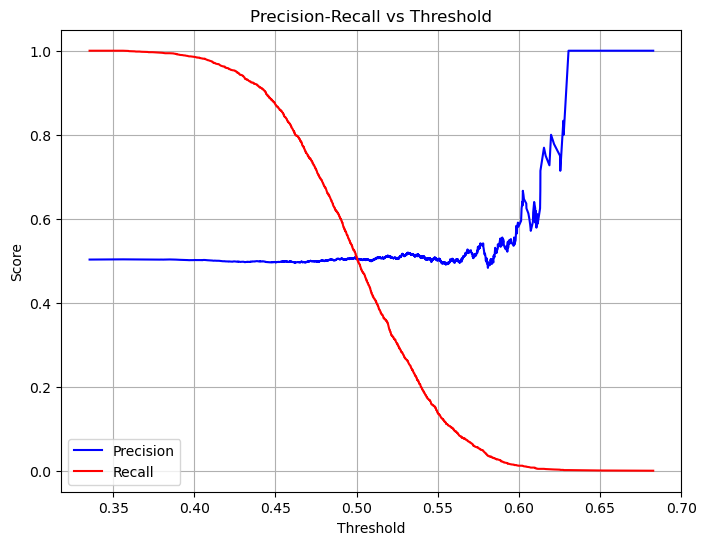

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()



The Precision-Recall vs Threshold curve shows how the model's precision (blue line) and recall (red line) change as we vary the threshold for labeling a news article as "Fake."  

- **Precision**: The proportion of articles labeled "Fake" that are actually fake.  
- **Recall**: The proportion of actual fake articles that are correctly identified.  

By adjusting the threshold, we can make the model more **conservative** (high threshold → fewer false positives) or more **sensitive** (low threshold → fewer false negatives).  

For example, setting the threshold to 0.8 increases precision but may reduce recall, meaning the model labels fewer articles as "Fake," but those it does label are more likely to be truly fake.


In [ ]:
**Random Forest with Stratified 5-Fold Cross-Validation**

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
rf_accuracies = []
rf_f1_scores = []
rf_precisions = []
rf_recalls = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"\nRF Fold {fold+1}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    rf_clf.fit(X_train, y_train)

    y_pred = rf_clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")

    rf_accuracies.append(acc)
    rf_f1_scores.append(f1)
    rf_precisions.append(prec)
    rf_recalls.append(rec)

    print("Accuracy:", acc)
    print("F1:", f1)

rf_accuracy = sum(rf_accuracies)/len(rf_accuracies)
rf_f1 = sum(rf_f1_scores)/len(rf_f1_scores)
rf_precision = sum(rf_precisions)/len(rf_precisions)
rf_recall = sum(rf_recalls)/len(rf_recalls)

print("\nRF Average Accuracy:", rf_accuracy)
print("RF Average F1:", rf_f1)




RF Fold 1
Accuracy: 0.52025
F1: 0.520214763494535

RF Fold 2
Accuracy: 0.5015
F1: 0.5013878011475719

RF Fold 3
Accuracy: 0.49825
F1: 0.498232594057579

RF Fold 4
Accuracy: 0.49625
F1: 0.4958149687121462

RF Fold 5
Accuracy: 0.4955
F1: 0.49516321526403706

RF Average Accuracy: 0.5023500000000001
RF Average F1: 0.5021626685351739


Comparison of the Accuracy and F1-score against the Logistic Regression baseline.



In [87]:
print("Model Comparison (Accuracy & F1-score)")
print("-" * 50)
print(f"Logistic Regression | Accuracy: {model_metrics['Logistic Regression']['Accuracy']:.4f} | F1-score: {model_metrics['Logistic Regression']['F1-Score']:.4f}")
print(f"Random Forest       | Accuracy: {model_metrics['Random Forest']['Accuracy']:.4f} | F1-score: {model_metrics['Random Forest']['F1-Score']:.4f}")


Model Comparison (Accuracy & F1-score)
--------------------------------------------------
Logistic Regression | Accuracy: 0.4982 | F1-score: 0.5006
Random Forest       | Accuracy: 0.5024 | F1-score: 0.5022


Multi-Model Comparison Table

In [85]:
# Dictionary to store model evaluation metrics
# Anyone who runs a model should add its metrics here.
# Format:
# model_metrics['Model Name'] = {
#     "Accuracy": ...,
#     "Precision": ...,
#     "Recall": ...,
#     "F1-Score": ...
# }

model_metrics = {}

# Dictionary to store model evaluation metrics
model_metrics = {}

model_metrics['Logistic Regression'] = {
    "Accuracy": avg_lr_accuracy,
    "Precision": avg_lr_precision,
    "Recall": avg_lr_recall,
    "F1-Score": avg_lr_f1

}


# Random Forest metrics
model_metrics['Random Forest'] = {
    "Accuracy": rf_accuracy,
    "Precision": rf_precision,
    "Recall": rf_recall,
    "F1-Score": rf_f1
}

for model_name in model_metrics:
    model_metrics[model_name]["Stopword Removal"] = REMOVE_STOPWORDS

print(model_metrics)

{'Logistic Regression': {'Accuracy': 0.49824999999999997, 'Precision': 0.5010138278240415, 'Recall': 0.5001979668483381, 'F1-Score': 0.5005577922877654, 'Stopword Removal': True}, 'Random Forest': {'Accuracy': 0.5023500000000001, 'Precision': 0.5022646037487084, 'Recall': 0.50235, 'F1-Score': 0.5021626685351739, 'Stopword Removal': True}}


In [89]:
#Summary Table

metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={"index": "Model Name"})
print(metrics_df)

            Model Name Accuracy Precision    Recall  F1-Score Stopword Removal
0  Logistic Regression  0.49825  0.501014  0.500198  0.500558             True
1        Random Forest  0.50235  0.502265   0.50235  0.502163             True


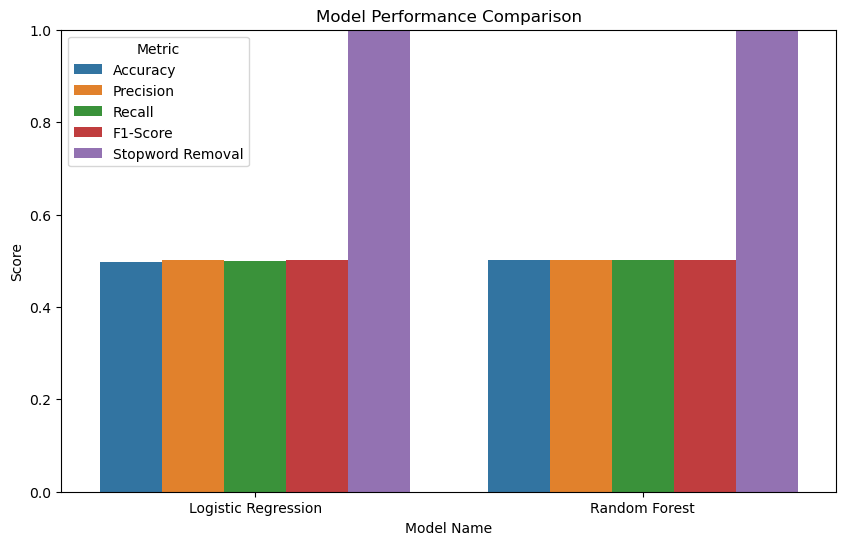

In [91]:
plt.figure(figsize=(10,6))
metrics_plot = metrics_df.melt(id_vars='Model Name', var_name='Metric', value_name='Score')
sns.barplot(data=metrics_plot, x='Model Name', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()

In [ ]:
**Documentation of the changes after using k-folds**

In [ ]:
Initially, the models were evaluated using a single train_test_split, which can lead to
biased performance estimates depending on how the dataset is randomly shuffled.
To obtain a more reliable evaluation, the fixed split was replaced with
Stratified 5-Fold Cross-Validation, ensuring balanced class distribution  across folds.

For Logistic Regression, the average accuracy after cross-validation showed only a
minor variation compared to the single split result, indicating that the model was
relatively stable across different data partitions.

For Random Forest, the accuracy improved from 0.4890 (single split) to 0.5024
(average across 5 folds). This suggests that the earlier single split slightly
underestimated the model’s true performance.

Overall, Stratified Cross-Validation provided a more stable and realistic estimate
of model accuracy for both models by reducing randomness and minimizing bias
introduced by a single train-test split.
